# TAOS2 - drifters1 campaign: hydrology unwrap

In [1]:
import os
from glob import glob

%matplotlib inline
import matplotlib.pyplot as plt
import cmocean.cm as cm

import numpy as np
import pandas as pd
import xarray as xr
import hvplot.pandas  # noqa
from scipy import integrate

#
import pynsitu as pin
from pynsitu.maps import crs
import taos.sensors as se

In [2]:
## taos
root_dir = "/Users/aponte/Current_Projects/taos/campagnes/taos2/"

# taos2-drifters0
campaign="taos2_drifters1"
yaml = f"drifters1/{campaign}.yaml"

cp = pin.Campaign(os.path.join(root_dir,yaml))

# yuco
p = "yuco"
Y = {d: cp.load(f'{p}_{d}.nc').to_dataframe() for d in cp[p].deployments()}

# ood
ood = cp.load("ood_drifter", toframe=True)

# smile
sm = cp.load(f'smile_ctd_main.nc')

# load tidal currents

# wind
#wind = cp.load("arome.nc")
wind = cp.load("arome.zarr")

In [3]:
# load observed sea level and tidal currents

#slvl = cp.load('tide_gauge_ouistreham.nc')

# start from actual sea level observations
root_dir_other = "/Users/aponte/Current_Projects/taos/campagnes/other/"
cpo = pin.Campaign(os.path.join(root_dir_other, "taos_other.yaml"))

nc = cpo.platforms["tide_gauge_ouistreham"]["files"]
tid = xr.open_dataset(nc)
tid = tid.sel(time=slice("2023/05/01", "2023/07/01"))

# tidally predict surface currents
_df = tid.to_dataframe()
ha_file = os.path.join(cpo["path_processed"], "smile_adcp_harmonics_surf.nc")
_df.ts.load_harmonics(ha_file, col=["ve_surf", "vn_surf"])
_df.ts.tidal_predict(["ve_surf", "vn_surf"], inplace=True)
tid["u"] = _df["ve_surf_tidal"]
tid["v"] = _df["vn_surf_tidal"]

# smile position need to be checked
lon_smile, lat_smile = cp["smile_ctd"]["lon"], cp["smile_ctd"]["lat"]

---

## compare smile and ood conductivity to calibrate it's value

In [5]:
ood = cp.load("ood_drifter", toframe=True)

ood_s = ood["station"]#.to_xarray()
ood_s["temperature_smile"] = sm["temperature"].interp(time=ood_s.index).values
ood_s["conductivity_smile"] = sm["conductivity"].interp(time=ood_s.index).values

ood_d = ood["drift"]#.to_xarray()
ood_d["temperature_smile"] = sm["temperature"].interp(time=ood_d.index).values
ood_d["conductivity_smile"] = sm["conductivity"].interp(time=ood_d.index).values

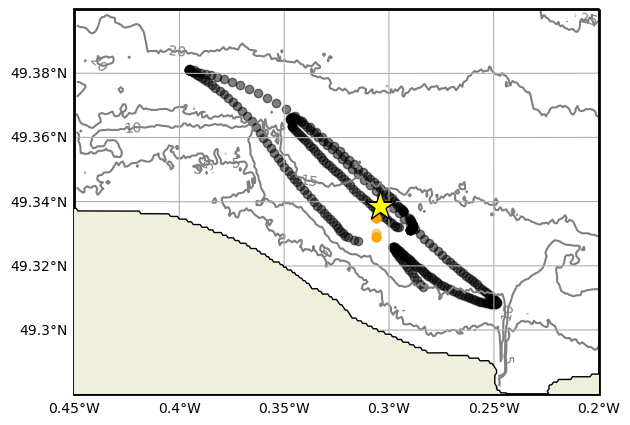

In [18]:
fig, ax, _ = cp.map(extent=(-0.45, -0.2, 49.28, 49.4))

ax.scatter(cp["smile_ctd"]["lon"], cp["smile_ctd"]["lat"], 
           s=500,  c=cp["smile_ctd"]["color"], transform=crs, marker="*", 
           edgecolor="k",
           zorder=10,
          )

h = ax.scatter(ood_d.longitude, ood_d.latitude, color="k", transform=crs, alpha=.5)
h = ax.scatter(ood_s.longitude, ood_s.latitude, color="orange", transform=crs, alpha=.5)

<Axes: xlabel='time'>

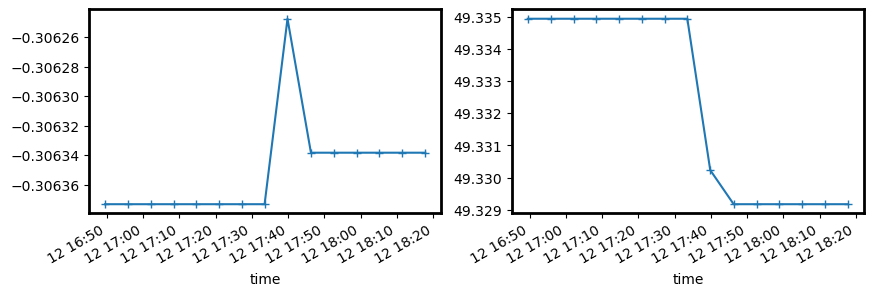

In [20]:
# station phase
fig, axes = plt.subplots(1,2, figsize=(10,3))
ood_s.longitude.plot(ax=axes[0], marker="+")
ood_s.latitude.plot(ax=axes[1], marker="+")

In [21]:
# correct position for an offset
lat_s, lon_s = ood_s.iloc[0][["latitude", "longitude"]]
lat_d, lon_d = ood_d.iloc[0][["latitude", "longitude"]]
print(lat_smile, lon_smile)
print(lat_s, lon_s)
print(lat_d, lon_d)

# correct only drift phase for now
ood_d["longitude"] = ood_d["longitude"] + (lon_smile - lon_d)
ood_d["latitude"] = ood_d["latitude"] + (lat_smile - lat_d)

49.33875 -0.30443
49.334957122802734 -0.30637326836586
49.32769775390625 -0.3147116303443908


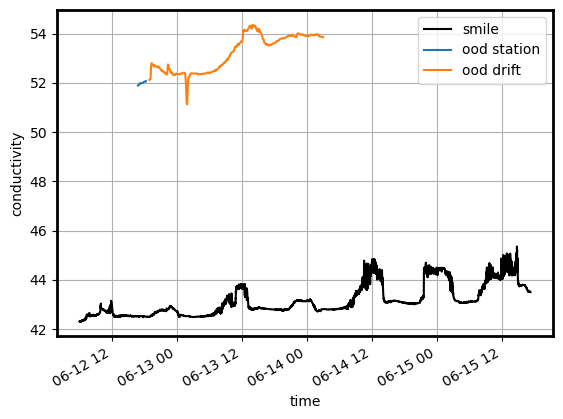

In [22]:
fig, ax = plt.subplots(1,1)

sm["conductivity"][:5_000].plot(label="smile", color="k")

ood_s["conductivity"].plot(label="ood station")
ood_d["conductivity"].plot(label="ood drift")

ax.grid()
ax.legend()

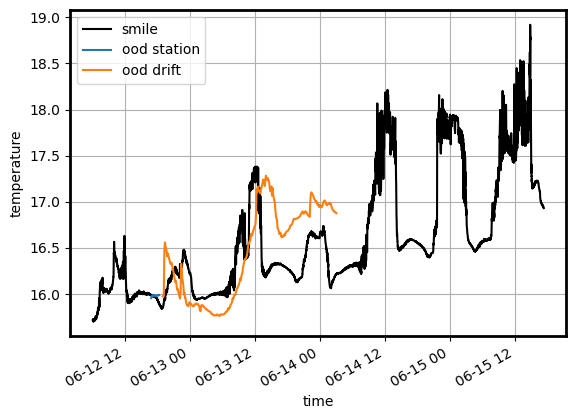

In [23]:
fig, ax = plt.subplots(1,1)

sm["temperature"][:5_000].plot(label="smile", color="k")

ood_s["temperature"].plot(label="ood station")
ood_d["temperature"].plot(label="ood drift")

ax.grid()
ax.legend()

In [24]:
delta_t = float(ood_s["temperature"].mean() - ood_s["temperature_smile"].mean())
delta_c = float(ood_s["conductivity"].mean() - ood_s["conductivity_smile"].mean())
delta_t, delta_c

(0.02338471598991454, 9.475699408333327)

In [25]:
# apply offsets
ood_s["temperature"] += -delta_t
ood_s["conductivity"] += - delta_c
#
ood_d["temperature"] += -delta_t
ood_d["conductivity"] += - delta_c

# update eos variables
ood_s = ood_s.sw.reset(extra=["salinity"])
ood_d = ood_d.sw.reset(extra=["salinity"])

some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to fill in with correct values
some values of longitude and latitudes are NaN, you may want to fill in with correct values


Text(0.5, 1.0, '')

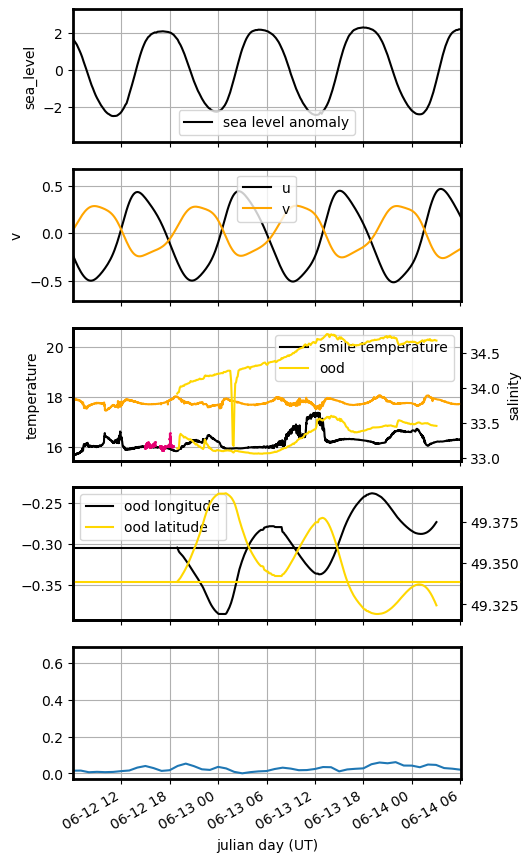

In [26]:
#fig, axes = plt.subplots(5,1, sharex=True, figsize=(10,10))
fig, axes = plt.subplots(5,1, sharex=True, figsize=(5,10))

ax = axes[0]
da = tid.sea_level - tid.sea_level.mean("time")
da.plot(ax=ax, label="sea level anomaly", color="k")
ax.set_xlabel("")
ax.grid()
ax.legend()

ax = axes[1]
da = tid.u
da.plot(ax=ax, label="u", color="k")
da = tid.v
da.plot(ax=ax, label="v", color="orange")
ax.set_xlabel("")
ax.grid()
ax.legend()

ax = axes[2]

da = sm["temperature"]
da.plot(ax=ax, label="smile temperature", color="k")
ood_d["temperature"].to_xarray().plot(ax=ax, label="ood", color=cp["ood_drifter"]["color"])

for d in ["d0", "d1", "d2", "d3"]:
    y = Y[d]
    y = y.loc[ y.depth<2.5 ].set_index("time").to_xarray()
    y.temperature.plot(ax=ax, ls="--", marker="o", markersize=1, color=cp["yuco"]["color"])

ax.set_xlabel("")
ax.grid()
ax.legend()

ax2 = ax.twinx()
da = sm["salinity"]
da.plot(ax=ax2, label="salinity", color="orange")
ood_d["salinity"].to_xarray().plot(ax=ax2, label="ood", color=cp["ood_drifter"]["color"])


ax = axes[3]
ax2 = ax.twinx()

#_l0 = ood_d["longitude"].plot(ax=ax, label="ood lon", color=cp["ood_drifter"]["color"])
_s = ood_d["longitude"]
_l0 = ax.plot(_s.index, _s, label="ood longitude", color="k")
ax.set_xlabel("")
ax.grid()
ax.axhline(lon_smile, color="k")

#_l1 = ood_d["latitude"].plot(ax=ax2, label="ood lat", ls="--", color=cp["ood_drifter"]["color"])
_s = ood_d["latitude"]
_l1 = ax2.plot(_s.index, _s, label="ood latitude", color=cp["ood_drifter"]["color"])
ax2.axhline(lat_smile, color=cp["ood_drifter"]["color"])

# added these three lines
_l = _l0 + _l1
labs = [l.get_label() for l in _l]
ax.legend(_l, labs, loc=0)

ax = axes[4]

lon, lat = cp["smile_ctd"]["lon"], cp["smile_ctd"]["lat"]
_w = wind.sel(longitude=lon, latitude=lat, method="nearest")

scale = -3600 # s
da = np.sqrt(_w.ustress**2+_w.vstress**2)/np.abs(scale)
da.plot(ax=ax)
ax.grid()

#ax.set_xlim(sm.time[0], sm.time[-1])
#ax.set_xlim(sm.time[0]- pd.Timedelta("5D"), sm.time[-1])
ax.set_xlim(sm.time[0], sm.time[0] + pd.Timedelta("2D"))
ax.set_title("")

Text(0.5, 1.0, '')

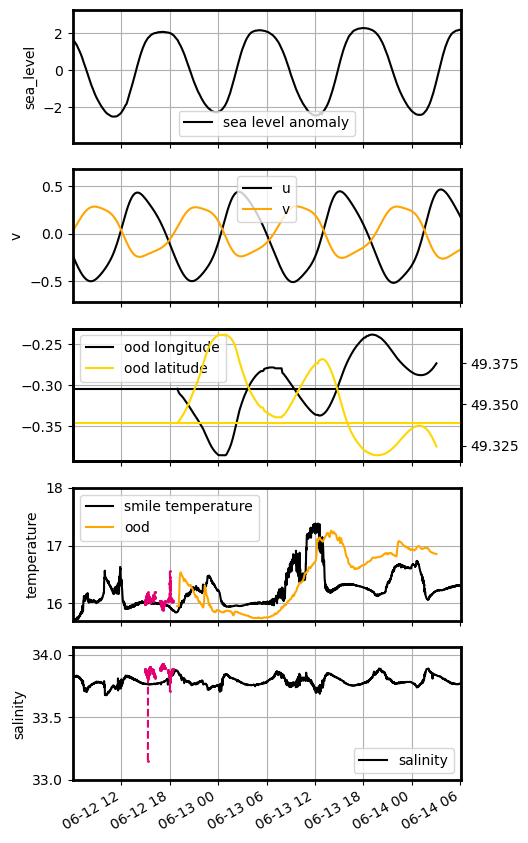

In [27]:
#fig, axes = plt.subplots(5,1, sharex=True, figsize=(10,10))
fig, axes = plt.subplots(5,1, sharex=True, figsize=(5,10))

##
ax = axes[0]
da = tid.sea_level - tid.sea_level.mean("time")
da.plot(ax=ax, label="sea level anomaly", color="k")
ax.set_xlabel("")
ax.grid()
ax.legend()

##
ax = axes[1]
da = tid.u
da.plot(ax=ax, label="u", color="k")
da = tid.v
da.plot(ax=ax, label="v", color="orange")
ax.set_xlabel("")
ax.grid()
ax.legend()

##
ax = axes[3]

da = sm["temperature"]
da.plot(ax=ax, label="smile temperature", color="k")
ood_d["temperature"].to_xarray().plot(ax=ax, label="ood", color="orange")

for d in ["d0", "d1", "d2", "d3"]:
    y = Y[d]
    y = y.loc[ y.depth<2.5 ].set_index("time").to_xarray()
    y.temperature.plot(ax=ax, ls="--", marker="o", markersize=1, color=cp["yuco"]["color"])

ax.set_xlabel("")
ax.grid()
ax.legend()
ax.set_ylim(15.7,18)

##
ax = axes[4]

da = sm["salinity"]
da.plot(ax=ax, label="salinity", color="k")
#ood_d["salinity"].to_xarray().plot(ax=ax, label="ood", color="orange")

for d in ["d0", "d1", "d2", "d3"]:
    y = Y[d]
    y = y.loc[ y.depth<2.5 ].set_index("time").to_xarray()
    y.salinity.plot(ax=ax, ls="--", marker="o", markersize=1, color=cp["yuco"]["color"])

ax.set_xlabel("")
ax.grid()
ax.legend()

##
ax = axes[2]

ax2 = ax.twinx()

#_l0 = ood_d["longitude"].plot(ax=ax, label="ood lon", color=cp["ood_drifter"]["color"])
_s = ood_d["longitude"]
_l0 = ax.plot(_s.index, _s, label="ood longitude", color="k")
ax.set_xlabel("")
ax.grid()
ax.axhline(lon_smile, color="k")

#_l1 = ood_d["latitude"].plot(ax=ax2, label="ood lat", ls="--", color=cp["ood_drifter"]["color"])
_s = ood_d["latitude"]
_l1 = ax2.plot(_s.index, _s, label="ood latitude", color=cp["ood_drifter"]["color"])
ax2.axhline(lat_smile, color=cp["ood_drifter"]["color"])

# added these three lines
_l = _l0 + _l1
labs = [l.get_label() for l in _l]
ax.legend(_l, labs, loc=0)

#ax.set_xlim(sm.time[0], sm.time[-1])
#ax.set_xlim(sm.time[0]- pd.Timedelta("5D"), sm.time[-1])
ax.set_xlim(sm.time[0], sm.time[0] + pd.Timedelta("2D"))
ax.set_title("")

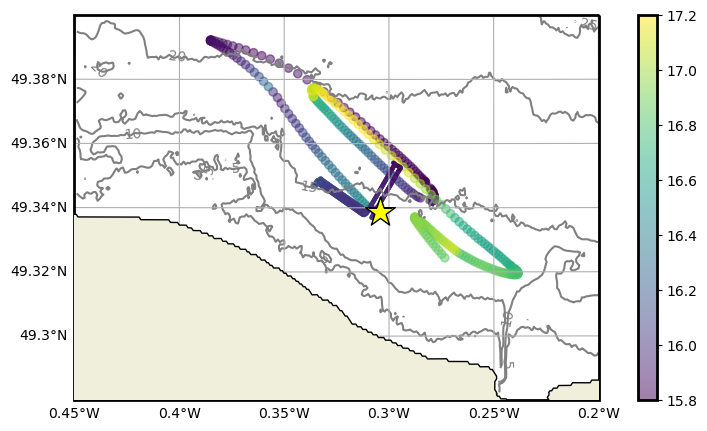

In [28]:
fig, ax, _ = cp.map(extent=(-0.45, -0.2, 49.28, 49.4))

ax.scatter(cp["smile_ctd"]["lon"], cp["smile_ctd"]["lat"], 
           s=500,  c=cp["smile_ctd"]["color"], transform=crs, marker="*", 
           edgecolor="k",
           zorder=10,
          )

vmin, vmax = 15.8, 17.2
h = ax.scatter(ood_d.longitude, ood_d.latitude, c=ood_d.temperature, transform=crs, alpha=.5, vmin=vmin, vmax=vmax)
ax.scatter(ood_d.longitude[0], ood_d.latitude[0], c=cp["ood_drifter"]["color"], transform=crs, marker="o", edgecolor="k")

for d in ["d0", "d1", "d2", "d3"]:
    y = Y[d]
    #y = y.loc[ y.depth<2.5 ]
    y = y.set_index("time").to_xarray()
    ax.scatter(y.longitude, y.latitude, c=y.temperature, s=5, transform=crs, alpha=.5, vmin=vmin, vmax=vmax)
    #ax.scatter(y.longitude[0], ood_d.latitude[0], c=cp["ood_drifter"]["color"], transform=crs, marker="o", edgecolor="k")
    
fig.colorbar(h)

In [29]:
_, _, ood_d["distance"] = pin.geo.azimuth_distance(ood_d.longitude*0+cp["smile_ctd"]["lon"], 
                         ood_d.longitude*0+cp["smile_ctd"]["lat"], 
                         ood_d.longitude, 
                         ood_d.latitude,
                        )

Text(0, 0.5, '[degC]')

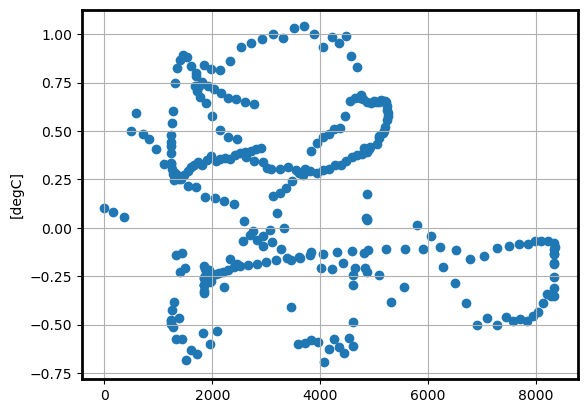

In [30]:
fig, ax = plt.subplots(1,1)

d = ood_d["distance"]
dtemp = ood_d["temperature"] - ood_d["temperature_smile"]

ax.scatter(d, dtemp)
ax.grid()
ax.set_ylabel("[degC]")

### make movie

In [31]:
import pynsitu.movies as movies

In [32]:
#map_gen = lambda : cp.map(extent=bounds, rivers=False, tile=("toner-lite", 12), land=False, bathy=False, coastline=False)
#extent = None
extent = cp["bounds"]
extent = (-0.45, -0.2, 49.28, 49.4)
figsize = (8,5)
#figsize = (10,5)

# or dynamic adjustment of extent
map_gen = lambda extent: cp.map(extent=extent, rivers=False, tile=("toner-lite", 11), 
                                land=False, bathy=False, coastline=False,
                                figsize=figsize,
                               )

kwargs = dict()
exclude = []

def func_ood(df, label, t, ax, dt_trail, **kw):
    dt_trail = pd.Timedelta(dt_trail)
    df = df.loc[ (df.index>=t-dt_trail) & (df.index<=t) ]
    h = ax.scatter(df.longitude, df.latitude, s=40, c=df.temperature, marker="s", 
                   vmin=15.7, vmax=17.5, cmap="inferno", transform=crs)
    plt.colorbar(h, shrink=1.)
kwargs["ood"] = dict(dtype="custom", data=ood["drift"], dt_trail="1H", func=func_ood)


def func_smile(df, label, t, ax, **kw):
    _sm = sm.sel(time=t, method="nearest")
    h = ax.scatter(lon_smile, lat_smile, s=80, c=float(_sm.temperature), 
                   vmin=15.7, vmax=17.5, cmap="inferno", transform=crs)
kwargs["smile"] = dict(dtype="custom", data=None, func=func_smile)


if extent is None:
    extent = dict(
        buffer=.1, # aspect_ratio should match figsize
        aspect_ratio=figsize,  
        exclude=exclude,
    )

#start = cp["start"] # +pd.Timedelta("3H")
#end = cp["end"] #+pd.Timedelta("1D")
start = ood_d.index[0].floor("10T")
end = ood_d.index[-1].ceil("10T")

# add vignete with tide
def extra(t, data, fig, ax):
    ax = fig.add_axes([.15, .2, .2, .2]) # (left, bottom, width, height)
    da = sm["temperature"]
    ax.plot(da.time, da, color="k")
    ax.plot(ood_d.index, ood_d.temperature, color="orange")
    #ax.plot(slvl["time"], slvl["sea_level"], color="k")
    #s = slvl.sea_level.interp(time=t)
    #ax.scatter(t, s, marker="o", color="r", s=10, zorder=10)
    #ax.axhline(s, color="r")
    ax.axvline(t, color="k")
    ax.set_xticklabels("")
    ax.set_ylim(15.7,17.5)
    dt = pd.Timedelta("1D")
    ax.set_xlim(t-dt, t+dt)
    ax.yaxis.tick_right()

mv = movies.movie(
    start, end, "10T",
    map_gen,
    os.path.join(cp["path_processed"], 'figs/'),
    extent=extent,
    **kwargs,
    extra=extra,
    #legend=True,
    #legend="upper right",
)

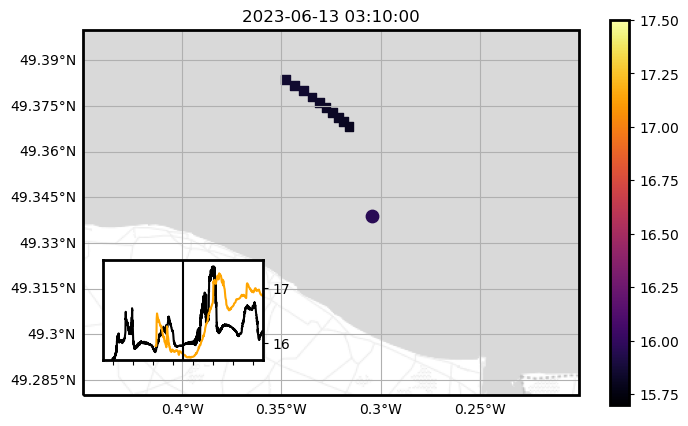

In [33]:
#mv.plot_snapshot(25);
mv.plot_snapshot(50);

In [34]:
mv.make_figures()

100%|██████████████████████████████████████████████████████████████████████████████████| 195/195 [01:57<00:00,  1.66it/s]


In [35]:
movies.generate_mpg(mv.fig_dir, cp["name"]+"_surface_hydrology")

movies should be ready at: /Users/aponte/Code/taos/insitu/taos2/taos2_drifters1_surface_hydrology.mp4


In [26]:
cp["name"]+"_surface_hydrology"

'taos2_drifters1_surface_hydrology'

In [ ]:

kwargs["drifters"] = dict(dtype="drifter", data=dr, colors=colorsd, dt_trail="1H", head_style=dict(alpha=0.5))

if cp["name"]=="taos2_drifters1":
    kwargs["odo"] = dict(dtype="moving", data=odo, color=cp["odo_drifter"]["color"], dt_trail="1H", head_style=dict(alpha=0.5, marker="*"))
    kwargs["yuco"] = dict(dtype="moving", data=yuco, color=cp["yuco"]["color"], dt_trail="1H", head_style=dict(alpha=0.5, marker="o"))
    exclude.append("yuco")

ship_trail = "1H"
if "hydrophone" in ship:
    kwargs["hydrophone"] = dict(dtype="moving", data=ship["hydrophone"], color=cp["hydrophone"]["color"], dt_trail=ship_trail)
    exclude.append("hydrophone")
if "parceque" in ship:
    kwargs["parceque"] = dict(dtype="moving", data=ship["parceque"], color=cp["parceque"]["color"], dt_trail=ship_trail)
    exclude.append("parceque")
if "delphy" in ship:
    kwargs["delphy"] = dict(dtype="moving", data=ship["delphy"], color=cp["delphy"]["color"], dt_trail=ship_trail)
    exclude.append("delphy")

kwargs["wind"] = dict(dtype="vector_field", data=wind, u="u10m", v="v10m", uref=10, di=3, scale=1e2, color="0.7")
exclude.append("wind")

In [ ]:
import matplotlib.dates as mdates
from matplotlib.patches import Rectangle

def plot_combined_deployments(wind_stress=True, quiver_scale=None):

    fig, axes = plt.subplots(4,1, figsize=(10,7))

    height=10
    y=0

    ax = axes[0]

    start = mdates.date2num(cp["start"])
    end = mdates.date2num(cp["end"])
    rect = Rectangle((start, y-height/2.), end-start, height,
                     color="orange")
    ax.add_patch(rect)
    ax.text(start, y+height*0.4, cp["name"])

    # sea level
    #_mtime = tid.index.map(lambda t: mdates.date2num(t))
    _mtime = mdates.date2num(tid.time)
    _tid = tid.sea_level - tid.sea_level.mean("time")
    ax.plot(_mtime, _tid, color="k", label="tidal sea level")

    delta_time = end - start + 10
    print(delta_time)

    def _set_axis(ax, xticklabels=True):

        ax.set_xlim(start-delta_time, end+delta_time)
        locator = mdates.AutoDateLocator(minticks=3)
        #formatter = mdates.AutoDateFormatter(locator)
        formatter = mdates.DateFormatter("%m-%d")
        ax.xaxis.set_major_locator(locator)
        ax.xaxis.set_major_formatter(formatter)
        if not xticklabels:
            ax.set_xticklabels([])
        ax.grid()

    _set_axis(ax, xticklabels=False)
    ax.legend(loc='lower center')
    ax.set_ylabel("[m]")
    ax.set_ylim(-5,5)

    ### wind sticks
    ax = axes[1]

    # wind data
    _mtime = mdates.date2num(wind.time)
    lon, lat = cp["smile_ctd"]["lon"], cp["smile_ctd"]["lat"]
    _w = wind.sel(longitude=lon, latitude=lat, method="nearest")
    _w_sub = _w.isel(time=slice(0,None,2))

    if wind_stress:
        scale = -3600 # s
        q = ax.quiver(_w_sub.time, _w_sub.ustress*0, 
                      _w_sub.ustress/scale, _w_sub.vstress/scale,
                      scale=quiver_scale,
                     )
        qk = ax.quiverkey(q, 0.8, 0.8, .2, r'$0.1\;Pa/m^2$', labelpos='E',
                           coordinates='axes')
    else:
        q = ax.quiver(_w_sub.time, _w_sub.u10m*0, 
                      _w_sub.u10m, _w_sub.v10m,
                      scale=quiver_scale,
                     )
        qk = ax.quiverkey(q, 0.8, 0.8, 10., r'$10\;m/s$', labelpos='E',
                           coordinates='axes')
    _set_axis(ax, xticklabels=False)
    
    
    ax = axes[2]
    _mtime = mdates.date2num(tid.time)
    _tid = tid.sea_level - tid.sea_level.mean("time")
    ax.plot(_mtime, _tid, color="k", label="tidal sea level")
    

    
    if False:
        ### wind strength
        if wind_stress:
            # wind stress
            _uvstress = np.sqrt(_w.ustress**2+_w.vstress**2)
            ax.plot(_mtime, _uvstress/scale, color="k", label="wind stress")
            ax.plot(_mtime, _w.ustress/scale, label="u stress")
            ax.plot(_mtime, _w.vstress/scale, label="v stress")
            ax.set_ylabel("[Pa]")
        else:
            # wind speed
            _uv10 = np.sqrt(_w.u10m**2+_w.v10m**2)
            ax.plot(_mtime, _uv10, color="k", label="wind speed")
            ax.plot(_mtime, _w.u10m, label="u")
            ax.plot(_mtime, _w.v10m, label="v")
            ax.set_ylabel("[m/s]")

    _set_axis(ax)
    ax.legend()


In [ ]:
plot_combined_deployments()